# Feed forward Neural Network - Vanilla Implementation
Download preprocessed data [here](https://drive.google.com/open?id=1xyDNsHHo0Ahptx66CqP2NBAAP6dVm3zn)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
data = pd.read_pickle("data.pkz")

In [3]:
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [4]:
# constants
layerLengths = [784, 15, 10]
layerCounts = len(layerLengths)
alpha = 1
num_iters = 100
epsilon = 1e-3

In [5]:
def generateY(y):
    m = y.shape[0]
    Y = np.zeros((layerLengths[-1], m))
    for i in range(m):
        Y[y.iloc[i], i] = 1
    return Y

def featureNormalize(X, mu=None, sigma=None):
    if mu is None:
        mu = np.mean(X.values)
    if sigma is None:
        sigma = np.std(X.values)
    return ((X - mu) / sigma, mu, sigma)


In [6]:
data_X = data.loc[:, "pixel0":]
data_y = data.loc[:, "label"]

data_X, mu, sigma = featureNormalize(data_X)
print(mu, sigma)
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2)

train_X = train_X.T
train_y = train_y.T
test_X = test_X.T
test_y = test_y.T

test_Y = generateY(test_y)
train_Y = generateY(train_y)

33.408911169825075 78.677739760763


In [7]:
# helper functions
def sigmoid (A):
    return 1 / (1 + np.exp(-A))

def prependWithValues(A, v = 1):
    return np.insert(A, 0, [v], axis=0)

def updateTheta(theta, delta):
    for i in range(layerCounts - 1):
        theta[i] -= delta[i] * alpha
    return theta
        
def initRandomTheta():
    theta = []
    for i in range(layerCounts - 1):
        l = layerLengths[i]
        nl = layerLengths[i + 1]
        theta.append(np.random.rand(nl, l + 1) * 2 - 1)
    return theta
        
def flattenTheta(theta):
    res = np.empty((0, 0))
    for t in theta:
        ft = t.flatten()
        res = np.append(res, ft)
    return res

def reshapeTheta(flatten_theta):
    theta = []
    s = 0
    for i in range(layerCounts - 1):
        w = layerLengths[i] + 1
        h = layerLengths[i + 1]
        segment = flatten_theta[s:s+w*h]
        theta.append(segment.reshape(h, w))
        s += w * h
    return theta

In [8]:
def forwardPropagation(X, theta):
    activations = [None] * layerCounts
    activations[0] = X.values
    for i in range(1, layerCounts):
        # insert bias unit into evaluation
        a = prependWithValues(activations[i - 1])
        activations[i] = sigmoid(theta[i - 1] @ a)
    return activations

In [9]:
def cost(X, Y, theta, lmbd=0):
    m = X.shape[1]
    activations = forwardPropagation(X, theta)
    h = activations[-1]
    reg_theta = [t[1:,:] for t in theta]
    reg_term = sum([np.sum((np.square(t))) for t in reg_theta]) * lmbd / (2 * m)
    J = np.sum(Y * np.log(h) + (1 - Y) * np.log(1 - h)) * (-1 / m) 
    return [J, activations]

In [10]:
def backwardPropagation(activations, Y, theta, lmbd=0):
    delta = []
    A = []
    YY = prependWithValues(Y)
    for t in theta:
        delta.append(np.zeros(t.shape))
    for i in range(len(activations)):
        A.append(prependWithValues(activations[i]))
    m = Y.shape[1]
    
    for caseId in range(m):
        act = []
        d = [None] * layerCounts
        y = YY[:, caseId]
        for i in range(layerCounts):
            act.append(A[i][:, caseId])
        d[-1] = act[-1] - y
        for i in range(layerCounts - 2, 0, -1):
            d[i] = theta[i].T @ d[i + 1][1:] * act[i] * (1 - act[i])
        for i in range(layerCounts - 1):
            delta[i] += d[i + 1][1:, None] @ act[i].reshape(1, len(act[i]))
    reg_theta = [t.copy() for t in theta]
    for i in range(layerCounts - 1):
        reg_theta[i][0, :] = [0]
        reg_theta[i] *= lmbd
    for i in range(layerCounts - 1):
        delta[i] = (delta[i] + reg_theta[i]) / m
    
    return delta

In [11]:
def estimateGradient(X, Y, theta):
    gradients = []
    fTheta = flattenTheta(theta)
    p = np.zeros(fTheta.shape)
    for i in range(len(fTheta)):
        p[i] = epsilon
        ht = reshapeTheta(fTheta + p)
        lt = reshapeTheta(fTheta - p)
        g = (cost(X, Y, ht)[0] - cost(X, Y, lt)[0]) / (2 * epsilon)
        gradients.append(g)
        p[i] = 0
    return np.array(gradients)
                

In [12]:
# gradient check
gtt = initRandomTheta()
id = [1, 2]
gtX = test_X.iloc[:, id]
gtY = test_Y[:, id]
eg = estimateGradient(gtX, gtY, gtt)
act = forwardPropagation(gtX, gtt)
g = backwardPropagation(act, gtY, gtt)
print("Highest difference between backprop gradient and estimated gradient: ",  max(flattenTheta(g) - eg))

Highest difference between backprop gradient and estimated gradient:  2.5000168368816134e-07


In [13]:
# train using whole batched gradient descent
def gradientDescent(X, Y, num_epoch=100, alpha=1, theta=None, print_cost=False, lmbd=1):
    if theta is None:
        theta = initRandomTheta()
    act = []
    costHistory = []
    for epoch in range(num_epoch):
        print("Training epoch: ", epoch)
        c, act = cost(X, Y, theta, lmbd)
        gradient = backwardPropagation(act, Y, theta, lmbd)
        theta = updateTheta(theta, gradient)
        costHistory.append(c)
        if print_cost:
            print(c)
        if costHistory[-1] - c >= 1e-7:
            break
    np.save("weight.npy",theta)
    return theta

In [14]:
# train using mini batch gradient descent
def getBatch(X, Y, batchSize):
    m = X.shape[1]
    idx = np.random.permutation(m)
    X, Y = X.iloc[:, idx], Y[:, idx]
    l = 0
    while True:
        h = min(l + batchSize, m)
        yield (X.iloc[:, l: h], Y[:, l: h])
        if h == m:
            break
        l = h

In [15]:
def miniBatchGradientDescent(X, Y, num_epoch=50, alpha=1, theta=None, print_cost=False, batch_size=200, lmbd=1):
    if theta is None:
        theta = initRandomTheta()
    act = []
    costHistory = []
    for epoch in range(num_epoch):
        print("Training epoch: ", epoch)
        for b_X, b_Y in getBatch(X, Y, batch_size):
            c, act = cost(b_X, b_Y, theta, lmbd)
            gradient = backwardPropagation(act, b_Y, theta, lmbd)
            theta = updateTheta(theta, gradient)
            costHistory.append(c)
            if print_cost:
                print(c)
    np.save("weight.npy",theta)
    plt.plot(costHistory)
    return theta

Training epoch:  0
Training epoch:  1
Training epoch:  2
Training epoch:  3
Training epoch:  4
Training epoch:  5
Training epoch:  6
Training epoch:  7
Training epoch:  8
Training epoch:  9
Training epoch:  10
Training epoch:  11
Training epoch:  12
Training epoch:  13
Training epoch:  14
Training epoch:  15
Training epoch:  16
Training epoch:  17
Training epoch:  18
Training epoch:  19
Training epoch:  20
Training epoch:  21
Training epoch:  22
Training epoch:  23
Training epoch:  24
Training epoch:  25
Training epoch:  26
Training epoch:  27
Training epoch:  28
Training epoch:  29
Training epoch:  30
Training epoch:  31
Training epoch:  32
Training epoch:  33
Training epoch:  34
Training epoch:  35
Training epoch:  36
Training epoch:  37
Training epoch:  38
Training epoch:  39
Training epoch:  40
Training epoch:  41
Training epoch:  42
Training epoch:  43
Training epoch:  44
Training epoch:  45
Training epoch:  46
Training epoch:  47
Training epoch:  48
Training epoch:  49
Final cost

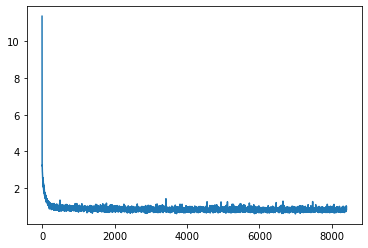

In [17]:
# Start training
%matplotlib inline
nn_theta = miniBatchGradientDescent(train_X, train_Y, num_epoch=50, alpha=3, lmbd=1)
# nn_theta = gradientDescent(train_X, train_Y, num_epoch=50, alpha=2, lmbd=5)
print("Final cost: ", cost(train_X, train_Y, nn_theta)[0])

In [19]:
def predict(X, theta):
    activations = forwardPropagation(X, theta)
    h = activations[-1]
    return (np.argmax(h, axis=0), h)

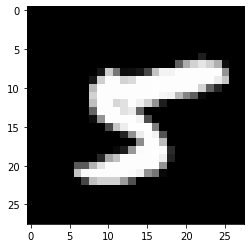

This is number : 5
Prediction probabilities:  [0.    0.037 0.003 0.015 0.013 0.935 0.01  0.038 0.015 0.005]


In [20]:
id = np.random.randint(0, test_X.shape[1])
tX = test_X.iloc[:, id]
tY = test_Y[:, id]
pixels = tX.values.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
res, prob = predict(tX, nn_theta)
print("This is number :", res)
print("Prediction probabilities: ", np.around(prob, decimals=3))

In [21]:
eval_X = test_X.iloc[:,]
eval_y = test_y[:]
res, _ = predict(eval_X, nn_theta)
correct_count = np.sum(res == eval_y)
total_count = eval_X.shape[1] 
print("Correctly predicted ", correct_count , " in ", total_count, " times")
print("Accuracy: ", correct_count / total_count * 100, "%")

Correctly predicted  7606  in  8400  times
Accuracy:  90.54761904761904 %


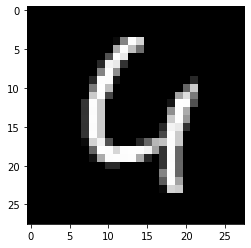

In [24]:
wrong_X = eval_X.loc[:, res != eval_y]
pixels = wrong_X.iloc[:,np.random.randint(0, len(wrong_X))].values.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()